# Import libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
spark = (
    SparkSession.builder
        .appName("Spark Clustering")
        .master("local[4]")
        .config("spark.log.level", "ERROR")
        .getOrCreate()
)

# Import data

In [ ]:
# Mock data from csv
df = spark.read.csv("/Users/1darknight/Python/Jupyter/Spark/mock_data.csv", header=True, inferSchema=True)
df.show()

+----------+---+------------+-------------+
|CustomerID|Age|AnnualIncome|SpendingScore|
+----------+---+------------+-------------+
|         1| 19|          15|           39|
|         2| 21|          15|           81|
|         3| 20|          16|            6|
|         4| 23|          16|           77|
|         5| 31|          17|           40|
|         6| 22|          17|           76|
|         7| 35|          18|            6|
|         8| 23|          18|           94|
|         9| 64|          19|            3|
|        10| 30|          19|           72|
|        11| 67|          19|           14|
|        12| 35|          19|           99|
|        13| 58|          20|           15|
|        14| 24|          20|           77|
|        15| 37|          20|           13|
|        16| 22|          20|           79|
|        17| 35|          21|           35|
|        18| 20|          21|           66|
|        19| 52|          23|           29|
|        20| 35|          23|   

# Correlation test

Spark doesn't have a direct method to test correlation across the dataset. Hence, here is the code to plot a heatmap using for loop:

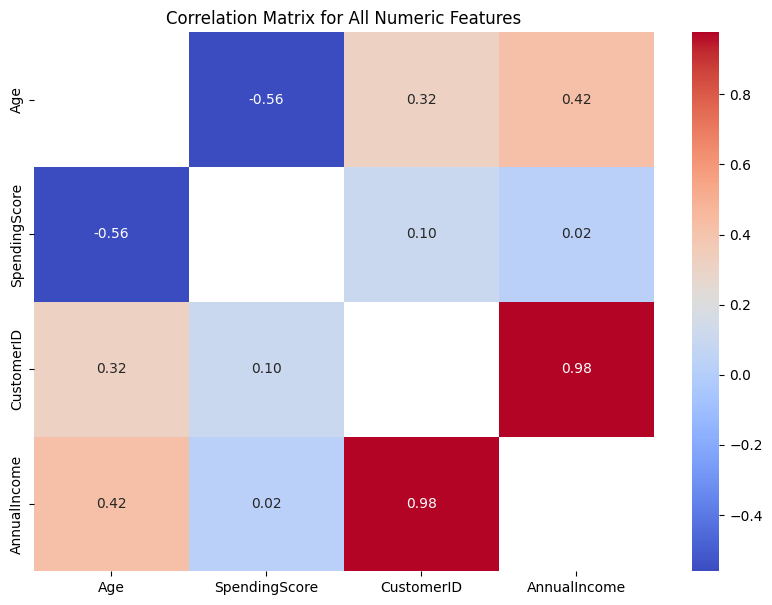

In [ ]:
# Filter numeric columns
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

# Create a dictionary to store correlation results
corr_dict = {}

# Compute pairwise correlations for all numeric columns
for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        col1 = numeric_cols[i]
        col2 = numeric_cols[j]
        corr_value = df.stat.corr(col1, col2)
        corr_dict[(col1, col2)] = corr_value  # Store as tuple key

# Convert correlation dictionary to Pandas DataFrame
# Prepare list of feature names
features = list(set([col for pair in corr_dict.keys() for col in pair]))

# Initialize an empty DataFrame to store the correlation matrix
corr_matrix = pd.DataFrame(index=features, columns=features)

# Fill in the correlation matrix with values
for (col1, col2), value in corr_dict.items():
    corr_matrix.loc[col1, col2] = value
    corr_matrix.loc[col2, col1] = value  # Correlation is symmetric

# Convert to numeric values
corr_matrix = corr_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for All Numeric Features")
plt.show()

# Clustering

Vector assembler is a method to append all feature's values into a column named "features" and use it for model functions

In [ ]:
# Create vector assembler for spark function
assembler = VectorAssembler(inputCols=["Age", "AnnualIncome", "SpendingScore"],
                            outputCol="features")
data = assembler.transform(df)

Here is the code for the Elbow method in Pyspark:

In [ ]:
# Elbow method
cost = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(data)
    cost.append(model.summary.trainingCost)


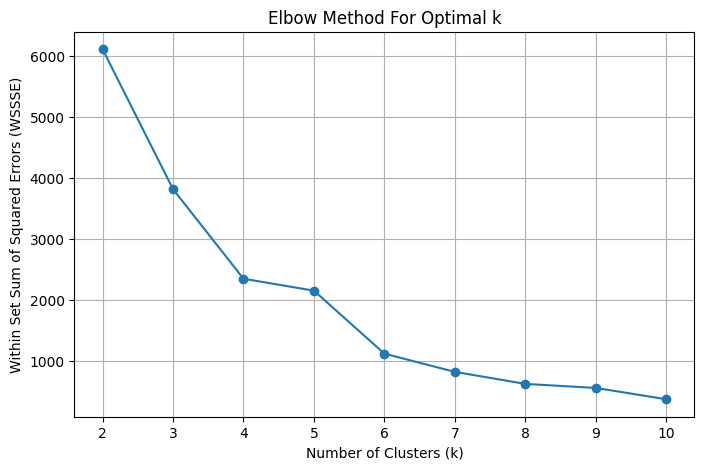

In [ ]:
# Visualize elbow method
plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method For Optimal k")
plt.grid(True)
plt.show()


PCA is needed to visualize the features:

In [55]:
# Reduce features to 2 principal components (2D)
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data)
pca_result = pca_model.transform(data)

# Cluster using best k (e.g. k=3)
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(data)
clustered = model.transform(pca_result)

# Assign the clusters back to original data
df_with_clusters = model.transform(data)

# Convert to Pandas for plotting
plot_df = clustered.select("pca_features", "cluster").toPandas()
plot_df[["x", "y"]] = plot_df["pca_features"].apply(lambda x: pd.Series(x.toArray()))


Here is the PCA after assigned the clusters:

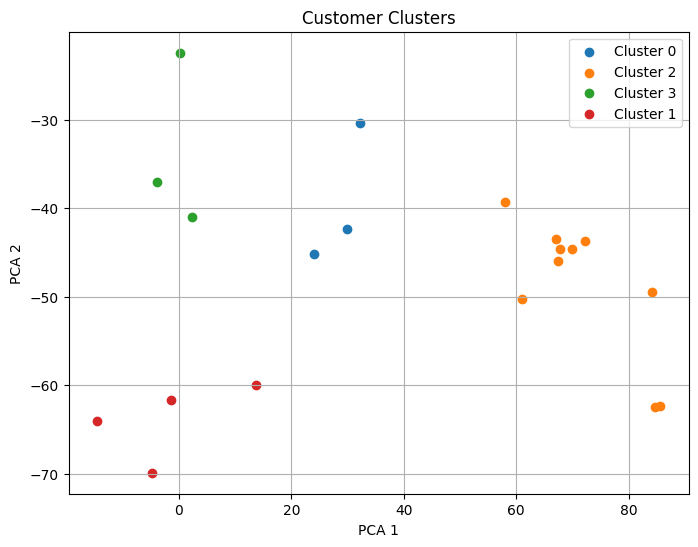

In [56]:
# Plot clusters
plt.figure(figsize=(8,6))
for label in plot_df["cluster"].unique():
    cluster = plot_df[plot_df["cluster"] == label]
    plt.scatter(cluster["x"], cluster["y"], label=f"Cluster {label}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Clusters")
plt.grid(True)
plt.show()


Here is the final dataset with assigned clusters:

In [57]:
df_with_clusters.show()

+----------+---+------------+-------------+----------------+-------+
|CustomerID|Age|AnnualIncome|SpendingScore|        features|cluster|
+----------+---+------------+-------------+----------------+-------+
|         1| 19|          15|           39|[19.0,15.0,39.0]|      0|
|         2| 21|          15|           81|[21.0,15.0,81.0]|      2|
|         3| 20|          16|            6| [20.0,16.0,6.0]|      3|
|         4| 23|          16|           77|[23.0,16.0,77.0]|      2|
|         5| 31|          17|           40|[31.0,17.0,40.0]|      0|
|         6| 22|          17|           76|[22.0,17.0,76.0]|      2|
|         7| 35|          18|            6| [35.0,18.0,6.0]|      3|
|         8| 23|          18|           94|[23.0,18.0,94.0]|      2|
|         9| 64|          19|            3| [64.0,19.0,3.0]|      1|
|        10| 30|          19|           72|[30.0,19.0,72.0]|      2|
|        11| 67|          19|           14|[67.0,19.0,14.0]|      1|
|        12| 35|          19|     